In [6]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

In [7]:
!pip install -q metloom

In [8]:
# Import the function to get connect to the db
from snowexsql.db import get_db

# This is what you will use for all of hackweek to access the db
db_name = 'snow:hackweek@db.snowexdata.org/snowex'

In [9]:
from snowexsql.data import PointData, ImageData

In [10]:
from metloom.pointdata import SnotelPointData
import geopandas as gpd

# Pull in Snotel point 
sntl_point = SnotelPointData("622:CO:SNTL", "Mesa Lakes")
geom = sntl_point.metadata
geom = gpd.GeoSeries(geom).set_crs(4326).to_crs(26912).geometry.values[0]


In [11]:
# import necessary libraries
from snowexsql.data import SiteData
from snowexsql.conversions import raster_to_rasterio, query_to_geopandas
from geoalchemy2.types import Raster
import geoalchemy2.functions as gfunc
from geoalchemy2.shape import from_shape,to_shape
from rasterio.plot import show
from sqlalchemy.sql import func
from datetime import date

In [57]:
# Buffer distance from site in meters
buffer_dist = 1000

# grab a session
engine, session = get_db(db_name)

# Building a buffer which will give us a buffer object around our point
buffer = session.query(gfunc.ST_SetSRID(gfunc.ST_Buffer(from_shape(geom), buffer_dist), 26912)).all()[0][0]

# Convert to a shapely shapefile object
circle = to_shape(buffer)

# Convert to a geopandas dataframe
df_circle = gpd.GeoSeries(circle)

# Grab the rasters, union them and convert them as tiff when done
q = session.query(func.ST_AsTiff(func.ST_Union(ImageData.raster, type_=Raster)))

# Only grab rasters that are the bare earth DEM from USGS
q = q.filter(ImageData.type == 'depth').filter(ImageData.observers=='ASO Inc.', ImageData.date==date(2020,2,2))

# And grab rasters touching the circle
q = q.filter(gfunc.ST_Intersects(ImageData.raster, buffer))

# Execute the query
rasters = q.all()

# Get the rasterio object of the raster
dataset = raster_to_rasterio(session, rasters)[0]

session.close()

In [97]:
shape = dataset.shape
data = dataset.read(1)

cols, rows = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))
xs, ys = rasterio.transform.xy(dataset.transform, rows, cols)
values = data.flatten()

xs = np.array([np.array(x) for x in xs])
ys = np.array([np.array(y) for y in ys])
points = gpd.points_from_xy(xs.flatten(), ys.flatten())

In [121]:
sntl_point = SnotelPointData("622:CO:SNTL", "dummy name")
station_data = sntl_point.get_daily_data(
    date(2020, 2, 1), date(2020, 2, 2),
    [sntl_point.ALLOWED_VARIABLES.SNOWDEPTH]
)

In [124]:
station_data['SNOWDEPTH']

datetime                   site       
2020-02-01 08:00:00+00:00  622:CO:SNTL    34.0
2020-02-02 08:00:00+00:00  622:CO:SNTL    33.0
Name: SNOWDEPTH, dtype: float64

(-0.1, 3.0)

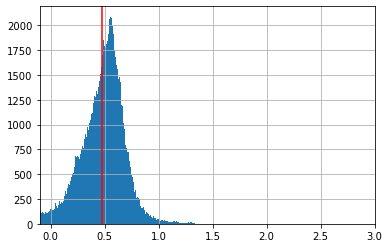

In [127]:
fig, ax = plt.subplots()
gdf = gpd.GeoDataFrame({'values':values, 'geometry':points}).dropna()
gdf = gdf[(gdf['values']>=0) & (gdf['values']<3)]
gdf['depth_difference'] = 34/25.4 - gdf['values']
gdf.crs = 26912
gdf['depth_difference'].hist(bins=1000, ax=ax)
ax.axvline(gdf['depth_difference'].mean(), color='red')
ax.set_xlim(-0.1,3)

/srv/conda/envs/notebook/lib/python3.10/site-packages/rasterio/plot.py:141: UserWarning: No contour levels were found within the data range.
  C = ax.contour(arr, origin='upper', **kwargs)


<AxesSubplot:>

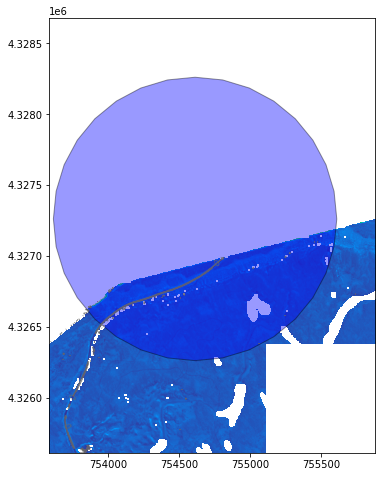

In [22]:
# Create a single plot to add everything to
fig, ax = plt.subplots(figsize=(8,8))

# Plot the DEM
img = show(dataset, ax=ax, transform=dataset.transform, cmap='terrain')

# Plot the contours of the DEM (Just for kicks!) at 10m intervals
show(dataset, contour=True, levels=[s for s in np.arange(3000, 4000, 10)], colors='dimgray', ax=ax, transform=dataset.transform)

# Plot the circle as blue with slight transparency
df_circle.plot(ax=ax, color='b', alpha=0.4, edgecolor='black')



In [119]:
sntl_point.get_daily_data?

Signature:
sntl_point.get_daily_data(
    start_date: datetime.datetime,
    end_date: datetime.datetime,
    variables: List[metloom.variables.SensorDescription],
)
Docstring: See docstring for PointData.get_daily_data
File:      /srv/conda/envs/notebook/lib/python3.10/site-packages/metloom/pointdata/snotel.py
Type:      method
